In [1]:
%run "..\..\..\Startup_py3.py"
sys.path.append(r"..\..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

84424


In [2]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_5\smFISH\test'

In [6]:
dax_files = [os.path.join(data_folder, _fl) for _fl in os.listdir(data_folder) if '.dax' in _fl]

In [7]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'


In [74]:
# load reference DAPI
reload(ia.classes.preprocess)
_ref_cls = ia.classes.preprocess.DaxProcesser(dax_files[0], 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
_ref_cls._load_image(sel_channels=[750,647,488,405])

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_5\smFISH\test\Conv_zscan_010.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '647', '488', '405'] in 5.798s.


In [75]:
_ref_cls._corr_illumination()

- Correct illumination for channels: ['750', '647', '488', '405']
-- Keep channels: ['750', '647', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 14.678s.
-- corrected illumination for channel 647 in 15.580s.
-- corrected illumination for channel 488 in 15.309s.
-- corrected illumination for channel 405 in 15.204s.
- Finished illumination correction in 61.150s.


In [76]:
_ref_cls._warp_image(corr_chromatic=True, correction_channels=['750'])

- Start warpping images channels:['750'].
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_50_2048_2048.npy


E:\Users\puzheng\Documents\ImageAnalysis3\classes\preprocess.py:799: UserWarning: drift not given to warp image. 
  warnings.warn(f"drift not given to warp image. ")


750 True False
-- warp image with chromatic abbrevation for channel: 750
-- finish warpping channel 750 in 111.479s.
-- finish warpping in 124.034s.


In [77]:
_ref_cls._gaussian_highpass([750,647])

- Apply Gaussian highpass for channels: ['750', '647']
-- Keep channels: ['750', '647'] for gaussian_highpass.
-- applying gaussian highpass, channel=750, sigma=3 in 16.282s
-- applying gaussian highpass, channel=647, sigma=3 in 15.124s
- Finished gaussian_highpass filtering in 31.407s.


In [69]:
_ref_cls.correction_log

{'750': {'corr_illumination': True,
  'warp_chromatic': True,
  'corr_highpass': True},
 '647': {'corr_illumination': True, 'corr_highpass': True},
 '488': {'corr_illumination': True},
 '405': {'corr_illumination': True}}

<IPython.core.display.Javascript object>


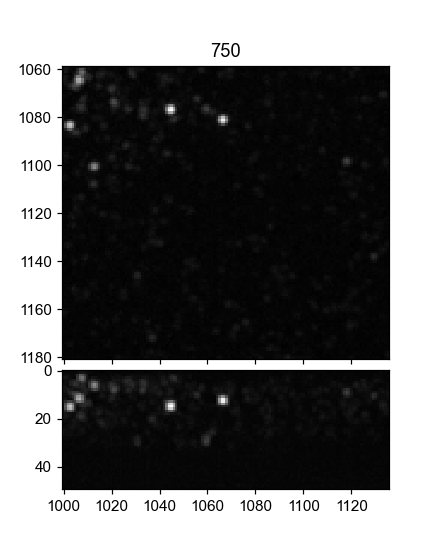

In [73]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_750, _ref_cls.im_647, _ref_cls.im_405],
                               image_names=['750','647','405'])

# Segmentation

In [55]:
from cellpose import models

In [58]:
%%time

test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in _ref_cls.im_405])
seg_model = models.CellposeModel(gpu=True, model_type='nuclei')

labels3d, _, _ = seg_model.eval(np.stack([test_dapi_im, test_dapi_im], axis=3), 
                                batch_size=20, anisotropy=250/108/2,
                                mask_threshold=0, 
                                channels=[0,0], 
                                diameter=30, 
                                min_size=100,
                                do_3D=True,
                                )
# resize segmentation label back
corr_labels3d = np.array([cv2.resize(_ly, _ref_cls.im_405.shape[1:], 
                                interpolation=cv2.INTER_NEAREST_EXACT) 
                     for _ly in labels3d])

In [62]:
# save
np.save(os.path.join(data_folder, dax_files[0].replace('.dax','_segmentation')), corr_labels3d)

In [93]:
from ImageAnalysis3.spot_tools.fitting import fit_fov_image



In [96]:
_fit_spots(_ref_cls, [750], overwrite=True)

- Fit spots in channels:['750']
-- Keep channels: ['750'] for fitting.
-- fitting channel=750 -- start fitting spots in channel:750, 4932 seeded with th=1000.0, 4932 fitted in 301.982s.
-- finish fitting in 302.250s.


<IPython.core.display.Javascript object>


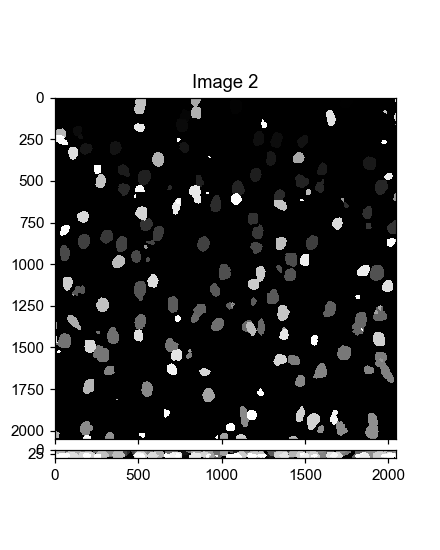

In [125]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, corr_labels3d])

# Fit

In [78]:
_ref_cls._fit_spots_by_segmentation('750', corr_labels3d, th_seed=1500)

- Start fitting spots in each segmentation


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [03:40<00:00,  1.13s/it]


In [116]:
coord_dict = {
    'coords':[np.flipud(_spot[1:4]) for _spot in _ref_cls.spots_750]+[np.flipud(_spot[1:4]) for _spot in _ref_cls.spots_647],
    'class_ids': list(0 * np.ones(len(_ref_cls.spots_750)))+list(1 * np.ones(len(_ref_cls.spots_647))),
}

<IPython.core.display.Javascript object>


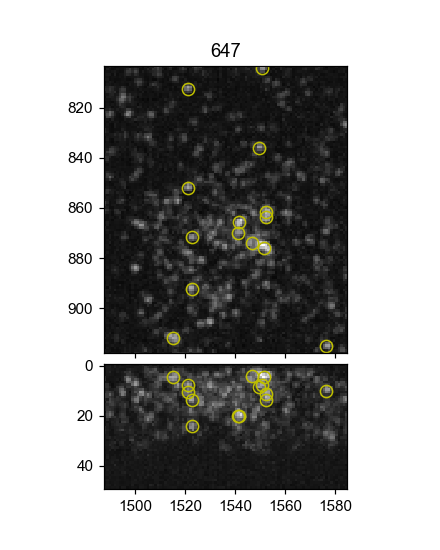

In [117]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_750, _ref_cls.im_647, _ref_cls.im_405],
                               given_dic=coord_dict,
                               image_names=['750','647','405'])

In [101]:
from scipy.spatial.distance import cdist

In [107]:
_coords1 = _ref_cls.spots_750[:,1:4] * np.array([250,108,108])
_coords2 = _ref_cls.spots_647[:,1:4] * np.array([250,108,108])

In [121]:
_inds1, _inds2 = np.where(cdist(_coords1, _coords2)<300)

In [122]:
_sel_spots_750 = _ref_cls.spots_750[np.unique(_inds1)]
_sel_spots_647 = _ref_cls.spots_647[np.unique(_inds2)]

In [123]:
coord_dict = {
    'coords':[np.flipud(_spot[1:4]) for _spot in _sel_spots_750]+[np.flipud(_spot[1:4]) for _spot in _sel_spots_647],
    'class_ids': list(0 * np.ones(len(_sel_spots_750)))+list(1 * np.ones(len(_sel_spots_647))),
}

<IPython.core.display.Javascript object>


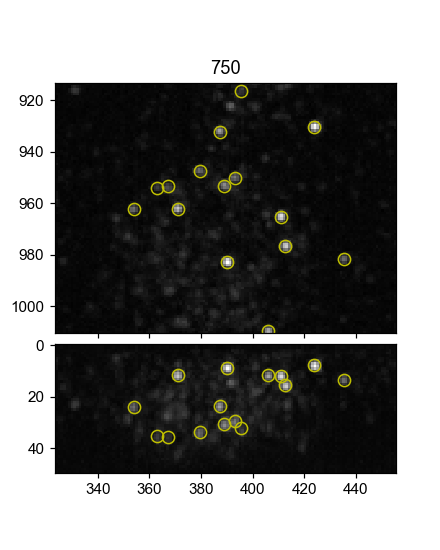

In [124]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_750, _ref_cls.im_647, _ref_cls.im_405],
                               given_dic=coord_dict,
                               image_names=['750','647','405'])